In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import pi
import os
import hydroeval as he
from sklearn.metrics import r2_score
from matplotlib import font_manager as fm
from matplotlib.ticker import ScalarFormatter
from metrics import NNSE,ZNRMSE,PPTS,LPTS
from ConvertChineseToPinyin import convert_to_pinyin_capitalized

# Set default font size to 9 and default linewidth to 1
plt.rcParams.update({'font.size': 8, 'lines.linewidth': 1})
hydro_stations = [
    'Tangnaihai', 
    'Guide', 
    'Xunhua']
hydrostation_abbrs = {'Tangnaihai':'TNH','Guide':'GD','Xunhua':'XH'}
hydrostation_channel = {'Tangnaihai':'3','Guide':'14','Xunhua':'9'}
# read observed climate data
hydrostation_metestations = {
    'Tangnaihai': [
        '玛多', '达日', '久治', '红原', '若尔盖', '玛曲', '玛沁', '河南', '兴海',
    ],
    'Guide': [
        '玛多', '达日', '久治', '红原', '若尔盖', '玛曲', '玛沁', '河南', '兴海',
        '贵南', '共和', '贵德',
    ],
    'Xunhua': [
        '玛多', '达日', '久治', '红原', '若尔盖', '玛曲', '玛沁', '河南', '兴海',
        '贵南', '共和', '贵德', '同仁',
    ]
}
metestation_controal_area = pd.read_csv('../data/MeteGaugeStationControlArea.csv')
metestation_controal_area_dict = dict(zip(metestation_controal_area['station'], metestation_controal_area['Shape_Area']))
# models = ['SARIMA','HCF-SWAT+','HCF-XGBoost','HCF-LSTM','HCF-SWAT+XGboost','HCF-SWAT+LSTM','GCMCF-SWAT+']
models = ['SARIMA','SWAT+','XGBoost','LSTM','SWAT+XGboost','SWAT+LSTM']

In [8]:
df = pd.read_table('D:/WorkSpace/SWATPlusCUPProjects/TNHHisCliPatACCESS.Spe.SwatPlusCup/Iterations/Iter1/Spe.Out/Single_Obj/single_obj_best_sim.txt',
                   skiprows=5,
                   sep=r'\s+')
df.columns = ['ObsFlow', 'PredFlow']
df.index = pd.date_range(start='1983-01-01',end='2007-12-31',freq='MS')
df.index.name = 'date'
df.to_csv('../result/HistoricalSimulationWithClimatePatternIn(ACCESS)/tangnaihai_monthly_flow_calibrated_using_GCM.csv')


df = pd.read_csv('D:/WorkSpace/SWATPlusCUPProjects/XHHisCliPatSimACCESS.Spe.SwatPlusCup/Iterations/Guide-Iter1/Spe.Out/Single_Obj/single_obj_best_sim.txt',
                 skiprows=5,
                 sep=r'\s+')
df.columns = ['ObsFlow', 'PredFlow']
df.index = pd.date_range(start='1983-01-01',end='2007-12-31',freq='MS')
df.index.name = 'date'
df.to_csv('../result/HistoricalSimulationWithClimatePatternIn(ACCESS)/guide_monthly_flow_calibrated_using_GCM.csv')

df = pd.read_csv('D:/WorkSpace/SWATPlusCUPProjects/XHHisCliPatSimACCESS.Spe.SwatPlusCup/Iterations/xunhua-Iter3/Spe.Out/Single_Obj/single_obj_best_sim.txt',
                 skiprows=5,
                 sep=r'\s+')
df.columns = ['ObsFlow', 'PredFlow']
df.index = pd.date_range(start='1983-01-01',end='2007-12-31',freq='MS')
df.index.name = 'date'
df.to_csv('../result/HistoricalSimulationWithClimatePatternIn(ACCESS)/xunhua_monthly_flow_calibrated_using_GCM.csv')



1. Visualize the simulation results (observed monthly streamflow versus simulated monthly streamflow; density scatters of observed and simulated monthly streamflow).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


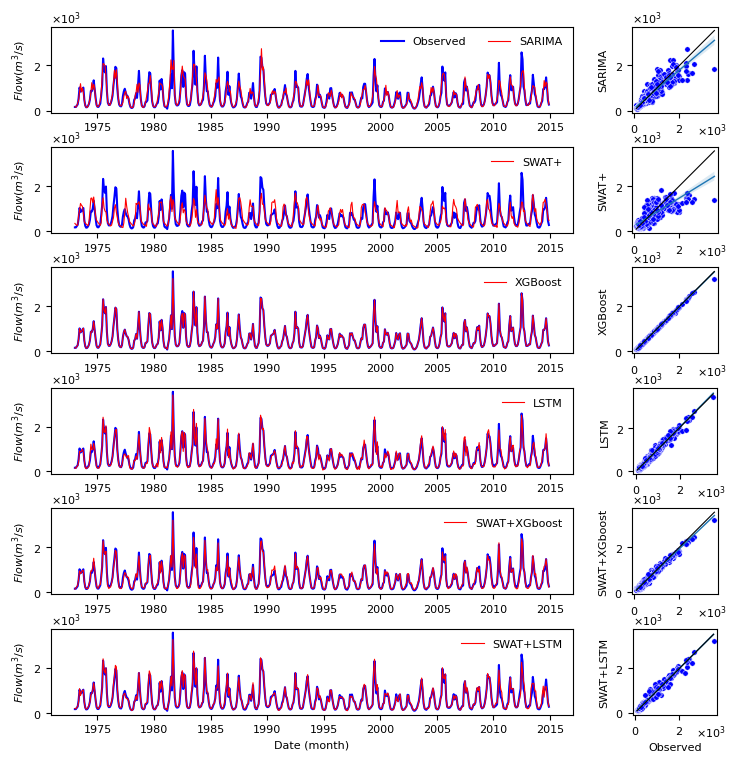

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


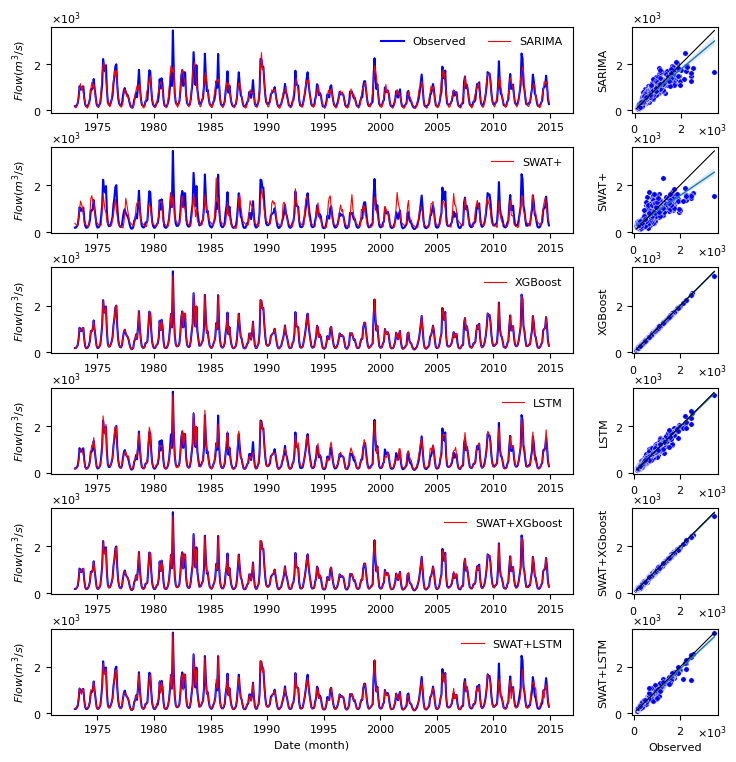

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


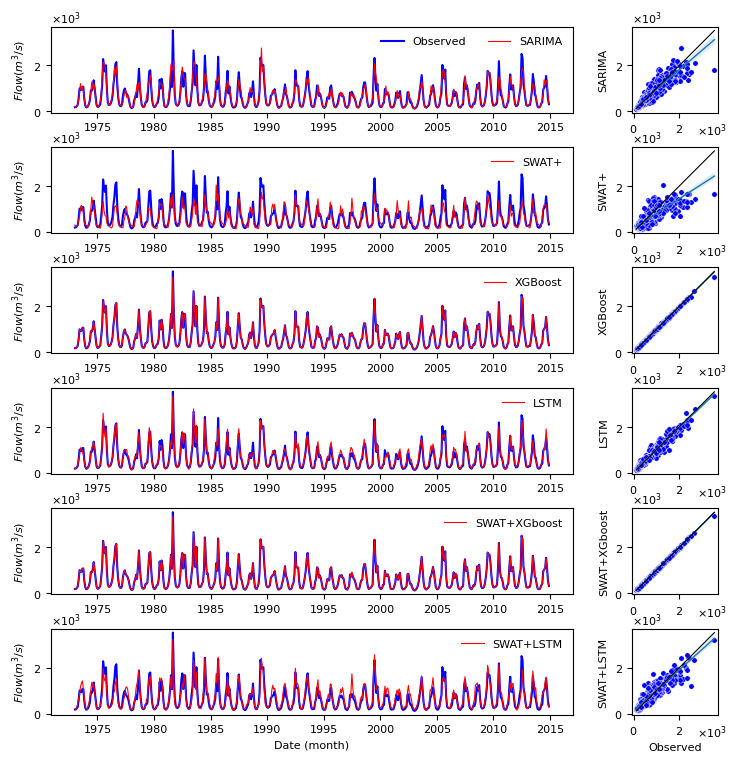

In [9]:

for hydro_station in hydro_stations:
    channel = hydrostation_channel[hydro_station]
    index = pd.date_range('1973-01-01','2014-12-31',freq='MS')
    
    obs = pd.read_csv(f'../data/{hydro_station.lower()}_natural_monthly_flow.csv',index_col=['date'],parse_dates=['date'])
    obs = obs.loc['1973-01-01':'2014-12-31','flow(m^3/s)']
    
    # load SARIMA results: date, flow(m^3/s), SimFlow(m^3/s)
    sarima = pd.read_csv(f'../result/ARIMAPredData/seasonal_decompose_multiplicative_arima_train_sim_{hydro_station.lower()}_before_2015.csv',index_col=['date'],parse_dates=['date'])
    sarima = sarima.loc['1973-01-01':'2014-12-31']
    sarima = sarima.rename(columns={'flow(m^3/s)':'obs','SimFlow(m^3/s)':'pred'})
    sarima.index = index
    # print(sarima)
    # load HCF-SWAT+ results: Date, Value
    hcf_swatp = pd.read_csv(f'../result/SWATPlusCalValSimData/Channel_{channel}_Monthly_River-Flow_{hydro_station}_Sim1972_2019.csv',index_col=['Date'],parse_dates=['Date'])
    hcf_swatp = hcf_swatp.loc['1973-01-01':'2014-12-31']
    hcf_swatp = hcf_swatp.rename(columns={'Value':'pred'})
    hcf_swatp.insert(0,'obs',obs.values)
    hcf_swatp.index = index
    # print(hcf_swatp)

    #load HCF-XGBoost results: date, obs, pred
    hcf_xgboost = pd.read_csv(f'../result/XGboostPredResult/{hydro_station}/InputOutputSamples_hydrosimyr/XGBoost_sim_1973_2015.csv',index_col=['date'],parse_dates=['date'])
    hcf_xgboost = hcf_xgboost.loc['1973-01-01':'2014-12-31']
    hcf_xgboost.index = index
    # print(hcf_xgboost)

    # load HCF-LSTM results: date, obs, pred
    hcf_lstm = pd.read_csv(f'../result/LSTMRegressorData/{hydro_station}/InputOutputSamples_hydrosimyr/cal_test_sim_1972_2014.csv',index_col=['date'],parse_dates=['date'])
    hcf_lstm = hcf_lstm.loc['1973-01-01':'2014-12-31']
    hcf_lstm.index = index
    # print(hcf_lstm)

    # load HCF-SWAT+XGBoost results: date, obs, pred
    hcf_swatp_xgboost = pd.read_csv(f'../result/XGboostPredResult/{hydro_station}/InputOutputSamples_hydrosimyr_swatpsim/XGBoost_sim_1973_2015.csv',index_col=['date'],parse_dates=['date'])
    hcf_swatp_xgboost = hcf_swatp_xgboost.loc['1973-01-01':'2014-12-31']
    hcf_swatp_xgboost.index = index
    # print(hcf_swatp_xgboost)
    # load HCF-SWAT+LSTM results: date, obs, pred
    hcf_swatp_lstm = pd.read_csv(f'../result/LSTMRegressorData/{hydro_station}/InputOutputSamples_hydrosimyr_swatpsim/cal_test_sim_1972_2014.csv',index_col=['date'],parse_dates=['date'])
    hcf_swatp_lstm = hcf_swatp_lstm.loc['1973-01-01':'2014-12-31']
    hcf_swatp_lstm.index = index
    # print(hcf_swatp_lstm)
    # load GCMCF-SWAT+ results: date, obs, pred
    gcmcf_swatp = pd.read_csv(f'../result/HistoricalSimulationWithClimatePatternIn(ACCESS)/{hydro_station.lower()}_monthly_flow_calibrated_using_GCM.csv',index_col=['date'],parse_dates=['date'])
    gcmcf_swatp = gcmcf_swatp.loc['1983-01-01':'2007-12-31']
    gcmcf_swatp.index = pd.date_range('1983-01-01','2007-12-31',freq='MS')
    gcmcf_swatp = gcmcf_swatp.rename(columns={'ObsFlow':'obs','PredFlow':'pred'})
    
    model_sims = [sarima,hcf_swatp,hcf_xgboost,hcf_lstm,hcf_swatp_xgboost,hcf_swatp_lstm]

    plt.figure(figsize=(7.48,7.48))
    ax1_13 = plt.subplot2grid((6,4), (0,0), colspan=3)
    ax1_34 = plt.subplot2grid((6,4), (0,3), colspan=1, aspect='equal')
    ax2_13 = plt.subplot2grid((6,4), (1,0), colspan=3)
    ax2_34 = plt.subplot2grid((6,4), (1,3), colspan=1, aspect='equal')
    ax3_13 = plt.subplot2grid((6,4), (2,0), colspan=3)
    ax3_34 = plt.subplot2grid((6,4), (2,3), colspan=1, aspect='equal')
    ax4_13 = plt.subplot2grid((6,4), (3,0), colspan=3)
    ax4_34 = plt.subplot2grid((6,4), (3,3), colspan=1, aspect='equal')
    ax5_13 = plt.subplot2grid((6,4), (4,0), colspan=3)
    ax5_34 = plt.subplot2grid((6,4), (4,3), colspan=1, aspect='equal')
    ax6_13 = plt.subplot2grid((6,4), (5,0), colspan=3)
    ax6_34 = plt.subplot2grid((6,4), (5,3), colspan=1, aspect='equal')

    axes = [[ax1_13,ax1_34],[ax2_13,ax2_34],[ax3_13,ax3_34],[ax4_13,ax4_34],
            [ax5_13,ax5_34],[ax6_13,ax6_34]]

    for i,model in enumerate(models):
        if i == 0:
            axes[i][0].plot(model_sims[i].index,model_sims[i]['obs'].values,label='Observed',color='blue',linewidth=1.5)
        else:
            axes[i][0].plot(model_sims[i].index,model_sims[i]['obs'].values,color='blue',linewidth=1.5)
        
        axes[i][0].plot(model_sims[i].index,model_sims[i]['pred'].values,label=model,color='red',linewidth=0.8)
        axes[i][0].set_ylabel('$Flow(m^3/s)$')
        axes[i][0].legend(ncol=2,loc='upper right',frameon=False)
        axes[i][0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[i][0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        if i==len(models)-1:
            axes[i][0].set_xlabel('Date (month)')

        sns.scatterplot(x=model_sims[i]['obs'].values, y=model_sims[i]['pred'].values, ax=axes[i][1], color='blue',s=15)
        
        # 添加线性拟合曲线
        sns.regplot(x=model_sims[i]['obs'], y=model_sims[i]['pred'], ax=axes[i][1], scatter=False, color='tab:blue', line_kws={'linewidth': 1}, label=None)
        
        min_val = min(model_sims[i]['obs'].min(), model_sims[i]['pred'].min())
        max_val = max(model_sims[i]['obs'].max(), model_sims[i]['pred'].max())
        axes[i][1].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=0.8)
        axes[i][1].set_ylabel(model)
        axes[i][1].yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
        axes[i][1].xaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
        axes[i][1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
        axes[i][1].tick_params(axis='both', which='major')
        if i==len(models)-1:
            axes[i][1].set_xlabel('Observed')
        else:
            axes[i][1].set_xlabel('')
        # 尝试使用其他方法调整科学计数法标识的位置
        axes[i][1].yaxis.offsetText.set_position((0.0, 1))
        axes[i][1].xaxis.offsetText.set_position((1.1, 1.5))
        axes[i][1].xaxis.offsetText.set_va('bottom')  # 设置垂直对齐方式为底部
        axes[i][1].xaxis.offsetText.set_ha('right')   # 设置水平对齐方式为右侧
    plt.subplots_adjust(left=0.05, right=0.99, top=0.98, bottom=0.06, wspace=0.15, hspace=0.4)
    # wspace控制子图之间的横向间距
    # hspace控制子图之间的纵向间距
    plt.savefig(f'../figs/ModelsSimulationResults_{hydro_station}.png',format='png',dpi=300)
    plt.savefig(f'../figs/ModelsSimulationResults_{hydro_station}.eps',format='eps',dpi=1000)
    plt.savefig(f'../figs/ModelsSimulationResults_{hydro_station}.tif', format='TIFF', dpi=500,bbox_inches='tight')
    plt.show()


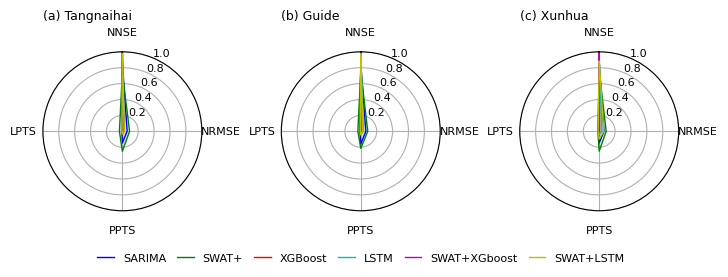

In [10]:
cal_metrics_dict = {}
val_metrics_dict = {}
metrics_dict = {}
for hydro_station in hydro_stations:
    channel = hydrostation_channel[hydro_station]
    index = pd.date_range('1973-01-01','2014-12-31',freq='MS')
    obs = pd.read_csv(f'../data/{hydro_station.lower()}_natural_monthly_flow.csv',index_col=['date'],parse_dates=['date'])
    obs = obs.loc['1973-01-01':'2014-12-31','flow(m^3/s)']
    
    # load SARIMA results: date, flow(m^3/s), SimFlow(m^3/s)
    sarima = pd.read_csv(f'../result/ARIMAPredData/seasonal_decompose_multiplicative_arima_train_sim_{hydro_station.lower()}_before_2015.csv',index_col=['date'],parse_dates=['date'])
    sarima = sarima.loc['1973-01-01':'2014-12-31']
    sarima = sarima.rename(columns={'flow(m^3/s)':'obs','SimFlow(m^3/s)':'pred'})
    sarima.index = index
    sarima_cal = sarima.loc[:'2009-12-31']
    sarima_val = sarima.loc['2010-01-01':]
    # print(sarima)
    # load HCF-SWAT+ results: Date, Value
    hcf_swatp = pd.read_csv(f'../result/SWATPlusCalValSimData/Channel_{channel}_Monthly_River-Flow_{hydro_station}_Sim1972_2019.csv',index_col=['Date'],parse_dates=['Date'])
    hcf_swatp = hcf_swatp.loc['1973-01-01':'2014-12-31']
    hcf_swatp = hcf_swatp.rename(columns={'Value':'pred'})
    hcf_swatp.insert(0,'obs',obs.values)
    hcf_swatp.index = index
    hcf_swatp_cal = hcf_swatp.loc[:'2009-12-31']
    hcf_swatp_val = hcf_swatp.loc['2010-01-01':]

    #load HCF-XGBoost results: date, obs, pred
    hcf_xgboost = pd.read_csv(f'../result/XGboostPredResult/{hydro_station}/InputOutputSamples_hydrosimyr/XGBoost_sim_1973_2015.csv',index_col=['date'],parse_dates=['date'])
    hcf_xgboost = hcf_xgboost.loc['1973-01-01':'2014-12-31']
    hcf_xgboost.index = index
    hcf_xgboost_cal = hcf_xgboost.loc[:'2009-12-31']
    hcf_xgboost_val = hcf_xgboost.loc['2010-01-01':]

    # load HCF-LSTM results: date, obs, pred
    hcf_lstm = pd.read_csv(f'../result/LSTMRegressorData/{hydro_station}/InputOutputSamples_hydrosimyr/cal_test_sim_1972_2014.csv',index_col=['date'],parse_dates=['date'])
    hcf_lstm = hcf_lstm.loc['1973-01-01':'2014-12-31']
    hcf_lstm.index = index
    hcf_lstm_cal = hcf_lstm.loc[:'2009-12-31']
    hcf_lstm_val = hcf_lstm.loc['2010-01-01':]

    # load HCF-SWAT+XGBoost results: date, obs, pred
    hcf_swatp_xgboost = pd.read_csv(f'../result/XGboostPredResult/{hydro_station}/InputOutputSamples_hydrosimyr_swatpsim/XGBoost_sim_1973_2015.csv',index_col=['date'],parse_dates=['date'])
    hcf_swatp_xgboost = hcf_swatp_xgboost.loc['1973-01-01':'2014-12-31']
    hcf_swatp_xgboost.index = index
    hcf_swatp_xgboost_cal = hcf_swatp_xgboost.loc[:'2009-12-31']    
    hcf_swatp_xgboost_val = hcf_swatp_xgboost.loc['2010-01-01':]
    # load HCF-SWAT+LSTM results: date, obs, pred
    hcf_swatp_lstm = pd.read_csv(f'../result/LSTMRegressorData/{hydro_station}/InputOutputSamples_hydrosimyr_swatpsim/cal_test_sim_1972_2014.csv',index_col=['date'],parse_dates=['date'])
    hcf_swatp_lstm = hcf_swatp_lstm.loc['1973-01-01':'2014-12-31']
    hcf_swatp_lstm.index = index
    hcf_swatp_lstm_cal = hcf_swatp_lstm.loc[:'2009-12-31']
    hcf_swatp_lstm_val = hcf_swatp_lstm.loc['2010-01-01':]
    # print(hcf_swatp_lstm)
    # load GCMCF-SWAT+ results: date, obs, pred
    gcmcf_swatplus = pd.read_csv(f'../result/HistoricalSimulationWithClimatePatternIn(ACCESS)/{hydro_station.lower()}_monthly_flow_calibrated_using_GCM.csv',index_col=['date'],parse_dates=['date'])
    gcmcf_swatplus = gcmcf_swatplus.loc['1983-01-01':'2007-12-31']
    gcmcf_swatplus.index = pd.date_range('1983-01-01','2007-12-31',freq='MS')
    gcmcf_swatplus = gcmcf_swatplus.rename(columns={'ObsFlow':'obs','PredFlow':'pred'})
    

    sarima_nnse = NNSE(sarima_cal['obs'],sarima_cal['pred'])
    sarima_znrmse = ZNRMSE(sarima['obs'],sarima['pred'])
    sarima_ppts = PPTS(sarima['obs'],sarima['pred'])
    sarima_lpts = LPTS(sarima['obs'],sarima['pred'])
    sarima_nse = float(he.evaluator(he.nse,sarima['obs'],sarima['pred'])[0])
    sarima_r2 = r2_score(sarima['obs'],sarima['pred'])
    sarima_kgenp = he.evaluator(he.kgenp,sarima['obs'],sarima['pred'])[0]
    sarima_pbias = he.evaluator(he.pbias,sarima['obs'],sarima['pred'])[0]

    hcf_swatp_nnse = NNSE(hcf_swatp['obs'],hcf_swatp['pred'])
    hcf_swatp_znrmse = ZNRMSE(hcf_swatp['obs'],hcf_swatp['pred'])
    hcf_swatp_ppts = PPTS(hcf_swatp['obs'],hcf_swatp['pred'])
    hcf_swatp_lpts = LPTS(hcf_swatp['obs'],hcf_swatp['pred'])
    hcf_swatp_nse = float(he.evaluator(he.nse,hcf_swatp['obs'],hcf_swatp['pred'])[0])
    hcf_swatp_r2 = r2_score(hcf_swatp['obs'],hcf_swatp['pred'])
    hcf_swatp_kgenp = he.evaluator(he.kgenp,hcf_swatp['obs'],hcf_swatp['pred'])[0]
    hcf_swatp_pbias = he.evaluator(he.pbias,hcf_swatp['obs'],hcf_swatp['pred'])[0]

    hcf_xgboost_nnse = NNSE(hcf_xgboost['obs'],hcf_xgboost['pred'])
    hcf_xgboost_znrmse = ZNRMSE(hcf_xgboost['obs'],hcf_xgboost['pred'])
    hcf_xgboost_ppts = PPTS(hcf_xgboost['obs'],hcf_xgboost['pred'])
    hcf_xgboost_lpts = LPTS(hcf_xgboost['obs'],hcf_xgboost['pred'])
    hcf_xgboost_nse = float(he.evaluator(he.nse,hcf_xgboost['obs'],hcf_xgboost['pred'])[0])
    hcf_xgboost_r2 = r2_score(hcf_xgboost['obs'],hcf_xgboost['pred'])
    hcf_xgboost_kgenp = he.evaluator(he.kgenp,hcf_xgboost['obs'],hcf_xgboost['pred'])[0]
    hcf_xgboost_pbias = he.evaluator(he.pbias,hcf_xgboost['obs'],hcf_xgboost['pred'])[0]

    hcf_lstm_nnse = NNSE(hcf_lstm['obs'],hcf_lstm['pred'])
    hcf_lstm_znrmse = ZNRMSE(hcf_lstm['obs'],hcf_lstm['pred'])
    hcf_lstm_ppts = PPTS(hcf_lstm['obs'],hcf_lstm['pred'])
    hcf_lstm_lpts = LPTS(hcf_lstm['obs'],hcf_lstm['pred'])
    hcf_lstm_nse = float(he.evaluator(he.nse,hcf_lstm['obs'],hcf_lstm['pred'])[0])
    hcf_lstm_r2 = r2_score(hcf_lstm['obs'],hcf_lstm['pred'])
    hcf_lstm_kgenp = he.evaluator(he.kgenp,hcf_lstm['obs'],hcf_lstm['pred'])[0]
    hcf_lstm_pbias = he.evaluator(he.pbias,hcf_lstm['obs'],hcf_lstm['pred'])[0]

    hcf_swatp_xgboost_nnse = NNSE(hcf_swatp_xgboost['obs'],hcf_swatp_xgboost['pred'])
    hcf_swatp_xgboost_znrmse = ZNRMSE(hcf_swatp_xgboost['obs'],hcf_swatp_xgboost['pred'])
    hcf_swatp_xgboost_ppts = PPTS(hcf_swatp_xgboost['obs'],hcf_swatp_xgboost['pred'])
    hcf_swatp_xgboost_lpts = LPTS(hcf_swatp_xgboost['obs'],hcf_swatp_xgboost['pred'])
    hcf_swatp_xgboost_nse = float(he.evaluator(he.nse,hcf_swatp_xgboost['obs'],hcf_swatp_xgboost['pred'])[0])
    hcf_swatp_xgboost_r2 = r2_score(hcf_swatp_xgboost['obs'],hcf_swatp_xgboost['pred'])
    hcf_swatp_xgboost_kgenp = he.evaluator(he.kgenp,hcf_swatp_xgboost['obs'],hcf_swatp_xgboost['pred'])[0]
    hcf_swatp_xgboost_pbias = he.evaluator(he.pbias,hcf_swatp_xgboost['obs'],hcf_swatp_xgboost['pred'])[0]

    hcf_swatp_lstm_nnse = NNSE(hcf_swatp_lstm['obs'],hcf_swatp_lstm['pred'])
    hcf_swatp_lstm_znrmse = ZNRMSE(hcf_swatp_lstm['obs'],hcf_swatp_lstm['pred'])
    hcf_swatp_lstm_ppts = PPTS(hcf_swatp_lstm['obs'],hcf_swatp_lstm['pred'])
    hcf_swatp_lstm_lpts = LPTS(hcf_swatp_lstm['obs'],hcf_swatp_lstm['pred'])
    hcf_swatp_lstm_nse = float(he.evaluator(he.nse,hcf_swatp_lstm['obs'],hcf_swatp_lstm['pred'])[0])
    hcf_swatp_lstm_r2 = r2_score(hcf_swatp_lstm['obs'],hcf_swatp_lstm['pred'])
    hcf_swatp_lstm_kgenp = he.evaluator(he.kgenp,hcf_swatp_lstm['obs'],hcf_swatp_lstm['pred'])[0]
    hcf_swatp_lstm_pbias = he.evaluator(he.pbias,hcf_swatp_lstm['obs'],hcf_swatp_lstm['pred'])[0]

    gcmcf_swatplus_nnse = NNSE(gcmcf_swatplus['obs'],gcmcf_swatplus['pred'])
    gcmcf_swatplus_znrmse = ZNRMSE(gcmcf_swatplus['obs'],gcmcf_swatplus['pred'])
    gcmcf_swatplus_ppts = PPTS(gcmcf_swatplus['obs'],gcmcf_swatplus['pred'])
    gcmcf_swatplus_lpts = LPTS(gcmcf_swatplus['obs'],gcmcf_swatplus['pred'])
    gcmcf_swatplus_nse = float(he.evaluator(he.nse,gcmcf_swatplus['obs'],gcmcf_swatplus['pred'])[0])
    gcmcf_swatplus_r2 = r2_score(gcmcf_swatplus['obs'],gcmcf_swatplus['pred'])
    gcmcf_swatplus_kgenp = he.evaluator(he.kgenp,gcmcf_swatplus['obs'],gcmcf_swatplus['pred'])[0]
    gcmcf_swatplus_pbias = he.evaluator(he.pbias,gcmcf_swatplus['obs'],gcmcf_swatplus['pred'])[0]

    sarima_cal_nnse = NNSE(sarima_cal['obs'],sarima_cal['pred'])
    sarima_val_nnse = NNSE(sarima_val['obs'],sarima_val['pred'])
    sarima_cal_znrmse = ZNRMSE(sarima_cal['obs'],sarima_cal['pred'])
    sarima_val_znrmse = ZNRMSE(sarima_val['obs'],sarima_val['pred'])
    sarima_cal_ppts = PPTS(sarima_cal['obs'],sarima_cal['pred'])
    sarima_val_ppts = PPTS(sarima_val['obs'],sarima_val['pred'])
    sarima_cal_lpts = LPTS(sarima_cal['obs'],sarima_cal['pred'])
    sarima_val_lpts = LPTS(sarima_val['obs'],sarima_val['pred'])
    sarima_cal_nse = float(he.evaluator(he.nse,sarima_cal['obs'],sarima_cal['pred'])[0])
    sarima_val_nse = float(he.evaluator(he.nse,sarima_val['obs'],sarima_val['pred'])[0])
    sarima_cal_r2 = r2_score(sarima_cal['obs'],sarima_cal['pred'])
    sarima_val_r2 = r2_score(sarima_val['obs'],sarima_val['pred'])
    sarima_cal_kgenp = he.evaluator(he.kgenp,sarima_cal['obs'],sarima_cal['pred'])[0]
    sarima_val_kgenp = he.evaluator(he.kgenp,sarima_val['obs'],sarima_val['pred'])[0]
    sarima_cal_pbias = he.evaluator(he.pbias,sarima_cal['obs'],sarima_cal['pred'])[0]
    sarima_val_pbias = he.evaluator(he.pbias,sarima_val['obs'],sarima_val['pred'])[0]

    hcf_swatp_cal_nnse = NNSE(hcf_swatp_cal['obs'],hcf_swatp_cal['pred'])
    hcf_swatp_val_nnse = NNSE(hcf_swatp_val['obs'],hcf_swatp_val['pred'])
    hcf_swatp_cal_znrmse = ZNRMSE(hcf_swatp_cal['obs'],hcf_swatp_cal['pred'])
    hcf_swatp_val_znrmse = ZNRMSE(hcf_swatp_val['obs'],hcf_swatp_val['pred'])
    hcf_swatp_cal_ppts = PPTS(hcf_swatp_cal['obs'],hcf_swatp_cal['pred'])
    hcf_swatp_val_ppts = PPTS(hcf_swatp_val['obs'],hcf_swatp_val['pred'])
    hcf_swatp_cal_lpts = LPTS(hcf_swatp_cal['obs'],hcf_swatp_cal['pred'])
    hcf_swatp_val_lpts = LPTS(hcf_swatp_val['obs'],hcf_swatp_val['pred'])
    hcf_swatp_cal_nse = float(he.evaluator(he.nse,hcf_swatp_cal['obs'],hcf_swatp_cal['pred'])[0])
    hcf_swatp_val_nse = float(he.evaluator(he.nse,hcf_swatp_val['obs'],hcf_swatp_val['pred'])[0])
    hcf_swatp_cal_r2 = r2_score(hcf_swatp_cal['obs'],hcf_swatp_cal['pred'])
    hcf_swatp_val_r2 = r2_score(hcf_swatp_val['obs'],hcf_swatp_val['pred'])
    hcf_swatp_cal_kgenp = he.evaluator(he.kgenp,hcf_swatp_cal['obs'],hcf_swatp_cal['pred'])[0]
    hcf_swatp_val_kgenp = he.evaluator(he.kgenp,hcf_swatp_val['obs'],hcf_swatp_val['pred'])[0]
    hcf_swatp_cal_pbias = he.evaluator(he.pbias,hcf_swatp_cal['obs'],hcf_swatp_cal['pred'])[0]
    hcf_swatp_val_pbias = he.evaluator(he.pbias,hcf_swatp_val['obs'],hcf_swatp_val['pred'])[0]

    hcf_xgboost_cal_nnse = NNSE(hcf_xgboost_cal['obs'],hcf_xgboost_cal['pred'])
    hcf_xgboost_val_nnse = NNSE(hcf_xgboost_val['obs'],hcf_xgboost_val['pred'])
    hcf_xgboost_cal_znrmse = ZNRMSE(hcf_xgboost_cal['obs'],hcf_xgboost_cal['pred'])
    hcf_xgboost_val_znrmse = ZNRMSE(hcf_xgboost_val['obs'],hcf_xgboost_val['pred'])
    hcf_xgboost_cal_ppts = PPTS(hcf_xgboost_cal['obs'],hcf_xgboost_cal['pred'])
    hcf_xgboost_val_ppts = PPTS(hcf_xgboost_val['obs'],hcf_xgboost_val['pred'])
    hcf_xgboost_cal_lpts = LPTS(hcf_xgboost_cal['obs'],hcf_xgboost_cal['pred'])
    hcf_xgboost_val_lpts = LPTS(hcf_xgboost_val['obs'],hcf_xgboost_val['pred'])
    hcf_xgboost_cal_nse = float(he.evaluator(he.nse,hcf_xgboost_cal['obs'],hcf_xgboost_cal['pred'])[0])
    hcf_xgboost_val_nse = float(he.evaluator(he.nse,hcf_xgboost_val['obs'],hcf_xgboost_val['pred'])[0])
    hcf_xgboost_cal_r2 = r2_score(hcf_xgboost_cal['obs'],hcf_xgboost_cal['pred'])
    hcf_xgboost_val_r2 = r2_score(hcf_xgboost_val['obs'],hcf_xgboost_val['pred'])
    hcf_xgboost_cal_kgenp = he.evaluator(he.kgenp,hcf_xgboost_cal['obs'],hcf_xgboost_cal['pred'])[0]
    hcf_xgboost_val_kgenp = he.evaluator(he.kgenp,hcf_xgboost_val['obs'],hcf_xgboost_val['pred'])[0]
    hcf_xgboost_cal_pbias = he.evaluator(he.pbias,hcf_xgboost_cal['obs'],hcf_xgboost_cal['pred'])[0]
    hcf_xgboost_val_pbias = he.evaluator(he.pbias,hcf_xgboost_val['obs'],hcf_xgboost_val['pred'])[0]

    hcf_lstm_cal_nnse = NNSE(hcf_lstm_cal['obs'],hcf_lstm_cal['pred'])
    hcf_lstm_val_nnse = NNSE(hcf_lstm_val['obs'],hcf_lstm_val['pred'])
    hcf_lstm_cal_znrmse = ZNRMSE(hcf_lstm_cal['obs'],hcf_lstm_cal['pred'])
    hcf_lstm_val_znrmse = ZNRMSE(hcf_lstm_val['obs'],hcf_lstm_val['pred'])
    hcf_lstm_cal_ppts = PPTS(hcf_lstm_cal['obs'],hcf_lstm_cal['pred'])
    hcf_lstm_val_ppts = PPTS(hcf_lstm_val['obs'],hcf_lstm_val['pred'])
    hcf_lstm_cal_lpts = LPTS(hcf_lstm_cal['obs'],hcf_lstm_cal['pred'])
    hcf_lstm_val_lpts = LPTS(hcf_lstm_val['obs'],hcf_lstm_val['pred'])
    hcf_lstm_cal_nse = float(he.evaluator(he.nse,hcf_lstm_cal['obs'],hcf_lstm_cal['pred'])[0])
    hcf_lstm_val_nse = float(he.evaluator(he.nse,hcf_lstm_val['obs'],hcf_lstm_val['pred'])[0])
    hcf_lstm_cal_r2 = r2_score(hcf_lstm_cal['obs'],hcf_lstm_cal['pred'])
    hcf_lstm_val_r2 = r2_score(hcf_lstm_val['obs'],hcf_lstm_val['pred'])
    hcf_lstm_cal_kgenp = he.evaluator(he.kgenp,hcf_lstm_cal['obs'],hcf_lstm_cal['pred'])[0]
    hcf_lstm_val_kgenp = he.evaluator(he.kgenp,hcf_lstm_val['obs'],hcf_lstm_val['pred'])[0]
    hcf_lstm_cal_pbias = he.evaluator(he.pbias,hcf_lstm_cal['obs'],hcf_lstm_cal['pred'])[0]
    hcf_lstm_val_pbias = he.evaluator(he.pbias,hcf_lstm_val['obs'],hcf_lstm_val['pred'])[0]

    hcf_swatp_xgboost_cal_nnse = NNSE(hcf_swatp_xgboost_cal['obs'],hcf_swatp_xgboost_cal['pred'])
    hcf_swatp_xgboost_val_nnse = NNSE(hcf_swatp_xgboost_val['obs'],hcf_swatp_xgboost_val['pred'])
    hcf_swatp_xgboost_cal_znrmse = ZNRMSE(hcf_swatp_xgboost_cal['obs'],hcf_swatp_xgboost_cal['pred'])
    hcf_swatp_xgboost_val_znrmse = ZNRMSE(hcf_swatp_xgboost_val['obs'],hcf_swatp_xgboost_val['pred'])
    hcf_swatp_xgboost_cal_ppts = PPTS(hcf_swatp_xgboost_cal['obs'],hcf_swatp_xgboost_cal['pred'])
    hcf_swatp_xgboost_val_ppts = PPTS(hcf_swatp_xgboost_val['obs'],hcf_swatp_xgboost_val['pred'])
    hcf_swatp_xgboost_cal_lpts = LPTS(hcf_swatp_xgboost_cal['obs'],hcf_swatp_xgboost_cal['pred'])
    hcf_swatp_xgboost_val_lpts = LPTS(hcf_swatp_xgboost_val['obs'],hcf_swatp_xgboost_val['pred'])
    hcf_swatp_xgboost_cal_nse = float(he.evaluator(he.nse,hcf_swatp_xgboost_cal['obs'],hcf_swatp_xgboost_cal['pred'])[0])
    hcf_swatp_xgboost_val_nse = float(he.evaluator(he.nse,hcf_swatp_xgboost_val['obs'],hcf_swatp_xgboost_val['pred'])[0])
    hcf_swatp_xgboost_cal_r2 = r2_score(hcf_swatp_xgboost_cal['obs'],hcf_swatp_xgboost_cal['pred'])
    hcf_swatp_xgboost_val_r2 = r2_score(hcf_swatp_xgboost_val['obs'],hcf_swatp_xgboost_val['pred'])
    hcf_swatp_xgboost_cal_kgenp = he.evaluator(he.kgenp,hcf_swatp_xgboost_cal['obs'],hcf_swatp_xgboost_cal['pred'])[0]
    hcf_swatp_xgboost_val_kgenp = he.evaluator(he.kgenp,hcf_swatp_xgboost_val['obs'],hcf_swatp_xgboost_val['pred'])[0]
    hcf_swatp_xgboost_cal_pbias = he.evaluator(he.pbias,hcf_swatp_xgboost_cal['obs'],hcf_swatp_xgboost_cal['pred'])[0]
    hcf_swatp_xgboost_val_pbias = he.evaluator(he.pbias,hcf_swatp_xgboost_val['obs'],hcf_swatp_xgboost_val['pred'])[0]

    hcf_swatp_lstm_cal_nnse = NNSE(hcf_swatp_lstm_cal['obs'],hcf_swatp_lstm_cal['pred'])
    hcf_swatp_lstm_val_nnse = NNSE(hcf_swatp_lstm_val['obs'],hcf_swatp_lstm_val['pred'])
    hcf_swatp_lstm_cal_znrmse = ZNRMSE(hcf_swatp_lstm_cal['obs'],hcf_swatp_lstm_cal['pred'])
    hcf_swatp_lstm_val_znrmse = ZNRMSE(hcf_swatp_lstm_val['obs'],hcf_swatp_lstm_val['pred'])
    hcf_swatp_lstm_cal_ppts = PPTS(hcf_swatp_lstm_cal['obs'],hcf_swatp_lstm_cal['pred'])
    hcf_swatp_lstm_val_ppts = PPTS(hcf_swatp_lstm_val['obs'],hcf_swatp_lstm_val['pred'])
    hcf_swatp_lstm_cal_lpts = LPTS(hcf_swatp_lstm_cal['obs'],hcf_swatp_lstm_cal['pred'])
    hcf_swatp_lstm_val_lpts = LPTS(hcf_swatp_lstm_val['obs'],hcf_swatp_lstm_val['pred'])
    hcf_swatp_lstm_cal_nse = float(he.evaluator(he.nse,hcf_swatp_lstm_cal['obs'],hcf_swatp_lstm_cal['pred'])[0])
    hcf_swatp_lstm_val_nse = float(he.evaluator(he.nse,hcf_swatp_lstm_val['obs'],hcf_swatp_lstm_val['pred'])[0])
    hcf_swatp_lstm_cal_r2 = r2_score(hcf_swatp_lstm_cal['obs'],hcf_swatp_lstm_cal['pred'])
    hcf_swatp_lstm_val_r2 = r2_score(hcf_swatp_lstm_val['obs'],hcf_swatp_lstm_val['pred'])
    hcf_swatp_lstm_cal_kgenp = he.evaluator(he.kgenp,hcf_swatp_lstm_cal['obs'],hcf_swatp_lstm_cal['pred'])[0]
    hcf_swatp_lstm_val_kgenp = he.evaluator(he.kgenp,hcf_swatp_lstm_val['obs'],hcf_swatp_lstm_val['pred'])[0]
    hcf_swatp_lstm_cal_pbias = he.evaluator(he.pbias,hcf_swatp_lstm_cal['obs'],hcf_swatp_lstm_cal['pred'])[0]
    hcf_swatp_lstm_val_pbias = he.evaluator(he.pbias,hcf_swatp_lstm_val['obs'],hcf_swatp_lstm_val['pred'])[0]

    metrics = pd.DataFrame({
        'Model': models,
        'NNSE': [sarima_nnse,hcf_swatp_nnse,hcf_xgboost_nnse,hcf_lstm_nnse,hcf_swatp_xgboost_nnse,hcf_swatp_lstm_nnse],
        'NRMSE': [sarima_znrmse,hcf_swatp_znrmse,hcf_xgboost_znrmse,hcf_lstm_znrmse,hcf_swatp_xgboost_znrmse,hcf_swatp_lstm_znrmse],
        'PPTS': [sarima_ppts,hcf_swatp_ppts,hcf_xgboost_ppts,hcf_lstm_ppts,hcf_swatp_xgboost_ppts,hcf_swatp_lstm_ppts],
        'LPTS': [sarima_lpts,hcf_swatp_lpts,hcf_xgboost_lpts,hcf_lstm_lpts,hcf_swatp_xgboost_lpts,hcf_swatp_lstm_lpts],
        'NSE': [sarima_nse,hcf_swatp_nse,hcf_xgboost_nse,hcf_lstm_nse,hcf_swatp_xgboost_nse,hcf_swatp_lstm_nse],
        'R2': [sarima_r2,hcf_swatp_r2,hcf_xgboost_r2,hcf_lstm_r2,hcf_swatp_xgboost_r2,hcf_swatp_lstm_r2],
        'KGE': [sarima_kgenp,hcf_swatp_kgenp,hcf_xgboost_kgenp,hcf_lstm_kgenp,hcf_swatp_xgboost_kgenp,hcf_swatp_lstm_kgenp],
        'PBIAS': [sarima_pbias,hcf_swatp_pbias,hcf_xgboost_pbias,hcf_lstm_pbias,hcf_swatp_xgboost_pbias,hcf_swatp_lstm_pbias],
    })
    metrics.index = models
    metrics_dict[hydro_station] = metrics
    cal_metrics = pd.DataFrame({
        'Model': models,
        'NNSE': [sarima_cal_nnse,hcf_swatp_cal_nnse,hcf_xgboost_cal_nnse,hcf_lstm_cal_nnse,hcf_swatp_xgboost_cal_nnse,hcf_swatp_lstm_cal_nnse],
        'NRMSE': [sarima_cal_znrmse,hcf_swatp_cal_znrmse,hcf_xgboost_cal_znrmse,hcf_lstm_cal_znrmse,hcf_swatp_xgboost_cal_znrmse,hcf_swatp_lstm_cal_znrmse],
        'PPTS': [sarima_cal_ppts,hcf_swatp_cal_ppts,hcf_xgboost_cal_ppts,hcf_lstm_cal_ppts,hcf_swatp_xgboost_cal_ppts,hcf_swatp_lstm_cal_ppts],
        'LPTS': [sarima_cal_lpts,hcf_swatp_cal_lpts,hcf_xgboost_cal_lpts,hcf_lstm_cal_lpts,hcf_swatp_xgboost_cal_lpts,hcf_swatp_lstm_cal_lpts],
        'NSE': [sarima_cal_nse,hcf_swatp_cal_nse,hcf_xgboost_cal_nse,hcf_lstm_cal_nse,hcf_swatp_xgboost_cal_nse,hcf_swatp_lstm_cal_nse],
        'R2': [sarima_cal_r2,hcf_swatp_cal_r2,hcf_xgboost_cal_r2,hcf_lstm_cal_r2,hcf_swatp_xgboost_cal_r2,hcf_swatp_lstm_cal_r2],
        'KGE': [sarima_cal_kgenp,hcf_swatp_cal_kgenp,hcf_xgboost_cal_kgenp,hcf_lstm_cal_kgenp,hcf_swatp_xgboost_cal_kgenp,hcf_swatp_lstm_cal_kgenp],
        'PBIAS': [sarima_cal_pbias,hcf_swatp_cal_pbias,hcf_xgboost_cal_pbias,hcf_lstm_cal_pbias,hcf_swatp_xgboost_cal_pbias,hcf_swatp_lstm_cal_pbias],
    })
    cal_metrics.index = models
    val_metrics = pd.DataFrame({
        'Model': models,
        'NNSE': [sarima_val_nnse,hcf_swatp_val_nnse,hcf_xgboost_val_nnse,hcf_lstm_val_nnse,hcf_swatp_xgboost_val_nnse,hcf_swatp_lstm_val_nnse],
        'NRMSE': [sarima_val_znrmse,hcf_swatp_val_znrmse,hcf_xgboost_val_znrmse,hcf_lstm_val_znrmse,hcf_swatp_xgboost_val_znrmse,hcf_swatp_lstm_val_znrmse],
        'PPTS': [sarima_val_ppts,hcf_swatp_val_ppts,hcf_xgboost_val_ppts,hcf_lstm_val_ppts,hcf_swatp_xgboost_val_ppts,hcf_swatp_lstm_val_ppts],
        'LPTS': [sarima_val_lpts,hcf_swatp_val_lpts,hcf_xgboost_val_lpts,hcf_lstm_val_lpts,hcf_swatp_xgboost_val_lpts,hcf_swatp_lstm_val_lpts],
        'NSE': [sarima_val_nse,hcf_swatp_val_nse,hcf_xgboost_val_nse,hcf_lstm_val_nse,hcf_swatp_xgboost_val_nse,hcf_swatp_lstm_val_nse],
        'R2': [sarima_val_r2,hcf_swatp_val_r2,hcf_xgboost_val_r2,hcf_lstm_val_r2,hcf_swatp_xgboost_val_r2,hcf_swatp_lstm_val_r2],
        'KGE': [sarima_val_kgenp,hcf_swatp_val_kgenp,hcf_xgboost_val_kgenp,hcf_lstm_val_kgenp,hcf_swatp_xgboost_val_kgenp,hcf_swatp_lstm_val_kgenp],
        'PBIAS': [sarima_val_pbias,hcf_swatp_val_pbias,hcf_xgboost_val_pbias,hcf_lstm_val_pbias,hcf_swatp_xgboost_val_pbias,hcf_swatp_lstm_val_pbias],
    })
    val_metrics.index = models

    cal_metrics_dict[hydro_station] = cal_metrics
    val_metrics_dict[hydro_station] = val_metrics

   
    metrics_path = f'../result/ModelEvaluationMetrics/'
    if not os.path.exists(metrics_path):
        os.makedirs(metrics_path)
    metrics.to_csv(f'{metrics_path}/{hydro_station}_evaluation_metrics.csv',index=False)
    cal_metrics.to_csv(f'{metrics_path}/{hydro_station}_cal_evaluation_metrics.csv',index=False)
    val_metrics.to_csv(f'{metrics_path}/{hydro_station}_val_evaluation_metrics.csv',index=False)



# Initialize the spider plot with 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(7.48, 4), subplot_kw=dict(projection='polar'))
fig_index = ['(a)','(b)','(c)']
for idx, hydro_station in enumerate(hydro_stations):
    metrics = pd.read_csv(f'../result/ModelEvaluationMetrics/{hydro_station}_evaluation_metrics.csv')
    # Select metrics for radar plot
    metrics_for_plot = metrics[['NNSE', 'NRMSE', 'PPTS', 'LPTS']]
    
    # Number of variables
    categories = list(metrics_for_plot.columns)
    N = len(categories)
    
    # Compute angle for each axis
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # First axis on top
    axes[idx].set_theta_offset(pi / 2)
    axes[idx].set_theta_direction(-1)
    
    # Draw axis lines for each angle and label
    axes[idx].set_xticks(angles[:-1])
    axes[idx].set_xticklabels(categories,fontsize=8)
    
    # Set the limit for the plot
    axes[idx].set_ylim(0, 1)
    
    # Plot data
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for model_idx, model in enumerate(models):
        values = metrics_for_plot.iloc[model_idx].values.flatten().tolist()
        values += values[:1]
        axes[idx].plot(angles, values, linewidth=1, linestyle='solid', label=model, color=colors[model_idx])
        axes[idx].fill(angles, values, colors[model_idx], alpha=0.1)
    
    # Add title
    axes[idx].set_title(f'{fig_index[idx]} {hydro_station}',loc='left',fontsize=9)
    
    # Only add legend for the last subplot
    if idx == 1:
        axes[idx].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6, fontsize=8,frameon=False,handlelength=1.5,columnspacing=1)

plt.subplots_adjust(left=0.05,right=0.9,bottom=0.1,top=0.9,wspace=0.5,hspace=0.1)
plt.savefig(f'../figs/ModelEvaluationRadarPlot_for_three_stations.png',dpi=300)
plt.savefig(f'../figs/ModelEvaluationRadarPlot_for_three_stations.tif',format='tif',dpi=600,bbox_inches='tight')
plt.show()

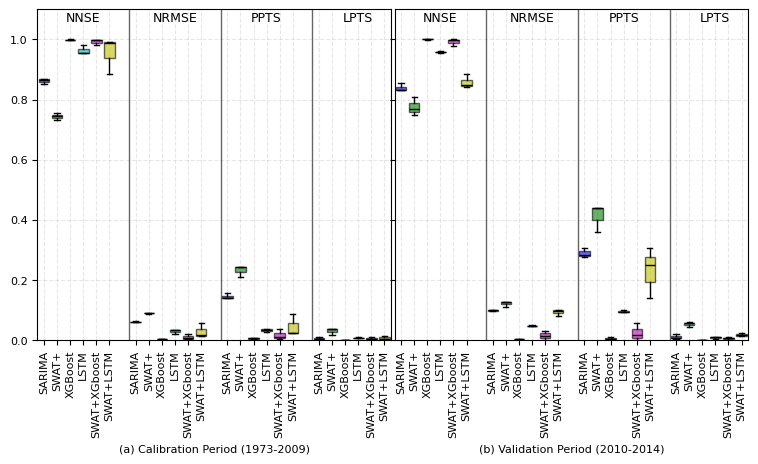

In [33]:
# Create figure with 2 subplots vertically arranged
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.48, 4.5))

# Prepare data for plotting
metrics = ['NNSE', 'NRMSE', 'PPTS', 'LPTS']
model_colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Function to prepare data for plotting
def prepare_boxplot_data(metrics_dict):
    data = []
    positions = []
    pos = 0
    for metric in metrics:
        metric_data = []
        for model in models:
            values = [metrics_dict[station].loc[model, metric] for station in hydro_stations]
            metric_data.append(values)
            positions.append(pos)
            pos += 1
        data.extend(metric_data)
        pos += 1  # Add space between metric groups
    return data, positions

# Prepare calibration and validation data
cal_data, positions = prepare_boxplot_data(cal_metrics_dict)
val_data, _ = prepare_boxplot_data(val_metrics_dict)

def create_boxplot(ax, data, title, show_legend=False, show_yticks=True):
    # Create boxplot
    bp = ax.boxplot(data, positions=positions, patch_artist=True, widths=0.8,
                    medianprops=dict(color="black"),
                    flierprops=dict(marker='o', markerfacecolor='gray', markersize=4))
    
    # Color boxes according to models
    for i, box in enumerate(bp['boxes']):
        box.set_facecolor(model_colors[i % len(models)])
        box.set_alpha(0.6)
    
    # Customize the plot
    ax.set_ylim(-0.0, 1.1)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_xlabel(title, labelpad=5)
    
    # Set x-ticks and labels
    all_ticks = []
    all_labels = []
    pos = 0
    for metric in metrics:
        metric_ticks = [pos + i for i in range(len(models))]
        all_ticks.extend(metric_ticks)
        all_labels.extend(models)
        pos += len(models) + 1
    
    ax.set_xticks(all_ticks)
    ax.set_xticklabels(all_labels, rotation=90, ha='center', fontsize=8)
    
    # Add vertical lines between metric groups
    for i in range(len(metrics)-1):
        pos = (i + 1) * (len(models) + 1) - 0.5
        ax.axvline(pos, color='black', linestyle='-', alpha=0.6)
    
    # Add metric labels using ax.text
    for i, metric in enumerate(metrics):
        pos = i * (len(models) + 1) + len(models)/2
        ax.text(pos, 1.05, metric, ha='center', va='bottom', fontsize=9)
    
    if not show_yticks:
        ax.set_yticklabels([])
        ax.set_ylabel('')

# Create the boxplots
create_boxplot(ax1, cal_data, '(a) Calibration Period (1973-2009)', show_legend=True, show_yticks=True)
create_boxplot(ax2, val_data, '(b) Validation Period (2010-2014)', show_legend=False, show_yticks=False)

# Adjust layout
plt.subplots_adjust(left=0.04, right=0.99, bottom=0.255, top=0.99, wspace=0.01, hspace=0.1)

# Save the figure
plt.savefig('../figs/ModelEvaluation_Boxplots.png', dpi=300)
plt.savefig('../figs/ModelEvaluation_Boxplots.tif', format='tif', dpi=500)
plt.show()

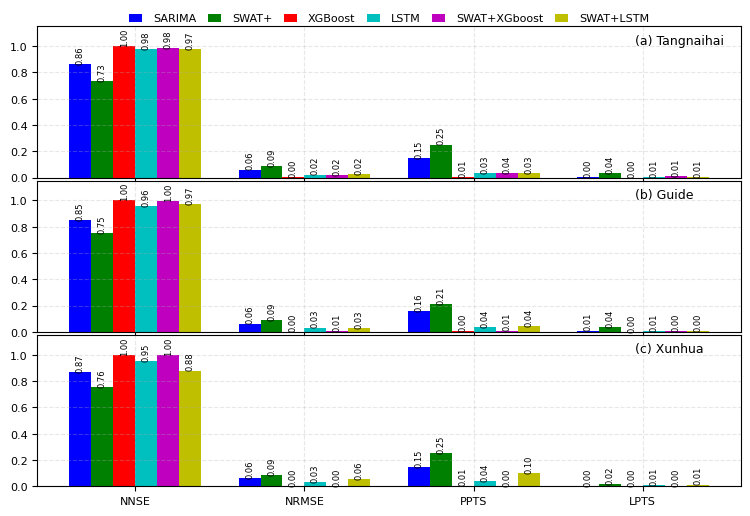

In [28]:
# Create figure with 3 subplots vertically arranged
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7.48, 5))
axes = [ax1, ax2, ax3]

# Set colors for different models
colors = ['b', 'g', 'r', 'c', 'm', 'y']
metrics_to_plot = ['NNSE', 'NRMSE', 'PPTS', 'LPTS']
bar_width = 0.13  # Width of each bar
index = np.arange(len(metrics_to_plot))  # X coordinates for groups

for idx, station in enumerate(hydro_stations):
    metrics_df = metrics_dict[station]
    
    # Plot bars for each model
    for i, model in enumerate(models):
        values = metrics_df.loc[model, metrics_to_plot]
        bars = axes[idx].bar(index + i*bar_width, values, bar_width, 
                           label=model if idx == 0 else "", 
                           color=colors[i])
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar_width/2, height,
                         f'{height:.2f}',
                         ha='center', va='bottom',
                         rotation=90, fontsize=6)
    
    # Customize the subplot
    axes[idx].set_ylim(0, 1.15)
    axes[idx].grid(True, linestyle='--', alpha=0.3)
    axes[idx].set_xticks(index + bar_width * 2.5)
    axes[idx].set_xticklabels(metrics_to_plot)
    axes[idx].text(0.85, 0.95, f'({chr(97+idx)}) {station}', transform=axes[idx].transAxes, fontsize=9, va='top')
    
    # Only show legend for the first subplot
    if idx == 0:
        axes[idx].legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', 
                        ncol=6, fontsize=8, frameon=False,handlelength=1.2,handletextpad=1,columnspacing=1)

# Adjust layout
plt.subplots_adjust(left=0.05, right=0.99, bottom=0.04, top=0.96, wspace=0.01, hspace=0.02)

# Save the figure
plt.savefig('../figs/ModelEvaluation_BarPlots.png', dpi=300)
plt.savefig('../figs/ModelEvaluation_BarPlots.tif', format='tif', dpi=500)
plt.show()